In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping
from tensorflow.keras.regularizers import l2
from wordcloud import WordCloud

%matplotlib inline

In [3]:
# !pip install wordcloud
# !pip install tensorflow.keras

## Reding ANIMELIST.CSV

In [4]:
import os

INPUT_DIR = os.path.join("..","artifacts","raw")


In [5]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv",
                        low_memory=True,
                        usecols=['user_id','anime_id','rating'])


In [6]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
print(len(rating_df))

5000000


## DATA PROCESSING

- Uniques USer Ratings
- filtered User with rating > 400 animes
- min,max,avg and scaling (X-min/max-min)
- Encoded and decoded mappings for user and anime
- create new user & anime cols with encoded mappping in df
- shuffled and Split data into X  & y and later into train and test
- create lists for user and anime


In [8]:
n_ratings = rating_df['user_id'].value_counts()
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [9]:
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings>=400].index)].copy()
len(rating_df)

3246641

In [10]:
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
avg_rating = np.mean(rating_df['rating'])

print(f"Min Rating: {min_rating}\nMax Rating : {max_rating}\nAverage Rating: {avg_rating}")

Min Rating: 0
Max Rating : 10
Average Rating: 4.122732695114736


In [11]:
# scale rating into 0-1 
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [12]:
rating_df['rating'].head(10)

213    0.0
214    1.0
215    0.0
216    0.0
217    0.0
218    0.8
219    0.8
220    0.9
221    0.0
222    0.0
Name: rating, dtype: float64

In [13]:
print(f"Scaled Min :{min_rating} \nScaled max: {max_rating}\nScaled Avg: {avg_rating}")

Scaled Min :0 
Scaled max: 10
Scaled Avg: 4.122732695114736


In [14]:
# Duplicates
rating_df.duplicated().sum()

np.int64(0)

In [15]:
# Missing values
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [16]:
# Unique USERS
user_ids = rating_df['user_id'].unique().tolist()
# Encoded users
user2user_encoded = { x : i for i,x in enumerate(user_ids)}
# Decoded users
user2user_decoded = { i : x for i,x in enumerate(user_ids)}
# Create unique user cols and ma into `rating_df`
rating_df['user'] = rating_df['user_id'].map(user2user_encoded)

In [17]:
n_users = len(user2user_encoded)
n_users

4203

In [18]:
## 11054 : 12 --> user2user encoded
## 12 : 11054 --> user2user decocded

In [19]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x : i for i,x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i,x in enumerate(anime_ids)}
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoded) 

In [20]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In [21]:
# we add randomness in our data so that our model can predcit on real like data
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


# COLS

ACTUAL  --->    user_id	anime_id

ENCODED --->	user	anime

In [22]:
X = rating_df[['user', 'anime']].values
y = rating_df['rating']

In [23]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [24]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices :],
)

In [25]:
len(X_test), len(y_test)

(1000, 1000)

In [26]:
# TYpe of Xtrain Xtest since model need np.arrays
type(X_train)

numpy.ndarray

In [27]:
# create sepate 2 rrays each for `user` features and `anime` feature
# Stores        USER data       ANIME data
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [28]:
type(X_train_array)

list

In [29]:
type(X_train_array[1])

numpy.ndarray

## MODEL ARCHITECTURE

In [30]:
# Create a tensorflow model 
def RecommenderNet():
    embedding_size = 128

    user = Input(name='user', shape=[1])

    user_embedding = Embedding(name='user_embedding', 
                               input_dim = n_users,
                               output_dim = embedding_size,
                               embeddings_regularizer=l2(1e-5))(user)
    anime = Input(name='anime', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', 
                               input_dim = n_anime,
                               output_dim = embedding_size,
                               embeddings_regularizer=l2(1e-5))(anime)
    
    # DOT Layer - dot product ---- similarity
    x = Dot(name='dot_product',
            normalize = True,
            axes = 2)([user_embedding, anime_embedding])
    
    # Flatten all output --- 128 dimenation vector into 1 dimensional
    x = Flatten()(x)

    # Dense, BatchNormaliztion, Activatio
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    # make a model Layer
    model = Model(inputs=[user, anime], outputs=x)
    # model.compile(loss='binary_crossentropy', metrics=['mae', 'mse'], optimizer='Adam')
    model.compile(loss='mean_squared_error', metrics=['mae', 'mse'], optimizer='Adam')

    return model



In [31]:
model = RecommenderNet()

In [32]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [33]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [34]:
# Callbacks
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                   save_weights_only=True,
                                   monitor="val_loss",
                                   mode="min",
                                   save_best_only=True)

early_stopping = EarlyStopping(patience=3,
                               monitor="val_loss",
                               mode="min",
                               restore_best_weights=True)

In [35]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [36]:
# Train the model -
# Store insisde `history` var so we can get grphs later

history = model.fit(
        x = X_train_array,
        y = y_train,
        batch_size=batch_size,
        epochs =20,
        verbose=1,
        validation_data = (X_test_array, y_test),
        callbacks = my_callbacks
    )

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - loss: 0.2181 - mae: 0.3812 - mse: 0.1956 - val_loss: 0.1842 - val_mae: 0.3586 - val_mse: 0.1619 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 77s 118ms/step - loss: 0.2162 - mae: 0.3799 - mse: 0.1942 - val_loss: 0.2054 - val_mae: 0.3678 - val_mse: 0.1836 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - loss: 0.2132 - mae: 0.3777 - mse: 0.1919 - val_loss: 0.2073 - val_mae: 0.3692 - val_mse: 0.1863 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - loss: 0.2090 - mae: 0.3744 - mse: 0.1885 - val_loss: 0.2053 - val_mae: 0.3685 - val_mse: 0.1852 - learning_rate: 3.4000e-05


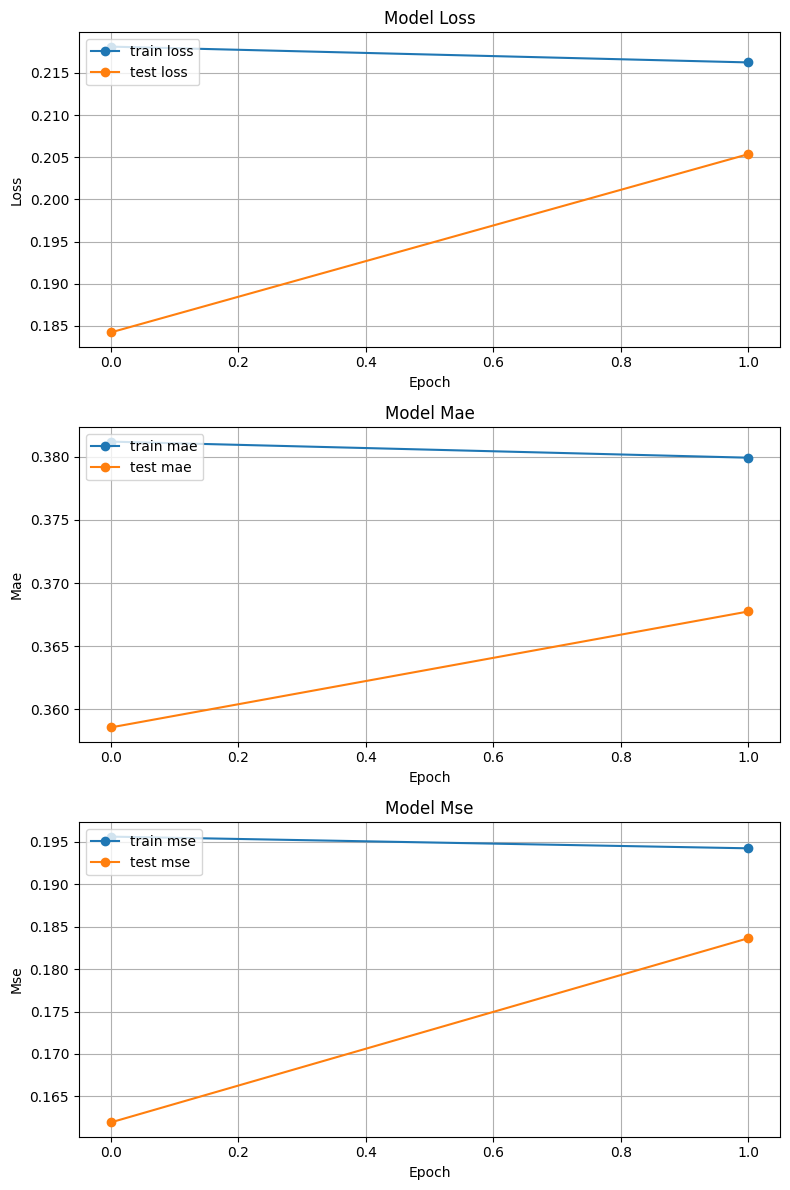

In [37]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [38]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [39]:
anime_weights = extract_weights("anime_embedding", model)


In [40]:
user_weights = extract_weights('user_embedding', model)

## READING ANIME.CSV 

In [41]:
anime_df = pd.read_csv(INPUT_DIR+"/anime.csv",
                       low_memory=True)
anime_df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [42]:
anime_df = anime_df.replace('Unknown', np.nan)

In [43]:
anime_df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [44]:
# To get English Name when name is unknow get Name
def getAnimeName(anime_id):
    try:
        name = anime_df[anime_df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = anime_df[anime_df.anime_id == anime_id].Name.values[0]
    except:
        print('Error')
    return name

In [45]:
anime_df["anime_id"] = anime_df["MAL_ID"]
anime_df["eng_version"] = anime_df["English name"]
anime_df["eng_version"] = anime_df.anime_id.apply(lambda x:getAnimeName(x))

In [46]:
getAnimeName(67)

'Basilisk'

In [47]:
getAnimeName(6702)

'Fairy Tail'

In [48]:
# Sort the anime df by score with descending order

anime_df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")


In [49]:
anime_df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [50]:
# Select Columns needed for analysis
anime_df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [51]:
anime_df = anime_df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]
anime_df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [52]:
# ANIME-ID or ANIME NAme will return the result of it
# 

def getAnimeFrame(anime,anime_df):
    if isinstance(anime,int):
        return anime_df[anime_df.anime_id == anime]
    if isinstance(anime, str):
        return anime_df[anime_df.eng_version == anime]

In [53]:
getAnimeFrame(40028 , anime_df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [54]:
getAnimeFrame('Steins;Gate', anime_df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


## Reading ANIME_WITH_SYNOPSIS.CSV

In [55]:
# Select COLS
cols = ['MAL_ID', 'Name','Genres', 'sypnopsis']

In [56]:
synopsis_df = pd.read_csv(INPUT_DIR+'/anime_with_synopsis.csv', usecols=cols)

In [57]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [58]:
# retunr Synopsis for anime_id or Anime_name
def getSynopsis(anime,anime_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [59]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [60]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

# Content/ITEM BAsed Recommendation SYStem

In [61]:
pd.set_option('max_colwidth', None)

In [62]:
def find_similar_animes(name, 
                        anime_weights,
                        anime2anime_encoded,
                        anime2anime_decoded,
                        anime_df,
                        synopsis_df,
                        n=10,
                        return_dist=False, 
                        neg=False):
    try:
        if name not in anime2anime_encoded:
            print(f"Anime {name} not found in encoding dictionary.")
            return None  
    
        # Get the index of the anime based on its name
        index = getAnimeFrame(name, anime_df).anime_id.values[0]  # gets index value
        encoded_index = anime2anime_encoded.get(index)  # Get encoded index

        if encoded_index is None:
            raise ValueError(f"Encoded index for anime '{name}' not found.")

        # Get the embeddings (weights)
        weights = anime_weights

        # Compute the similarity (dot product between weights)
        dists = np.dot(weights, weights[encoded_index])  # Compute the cosine similarity
        sorted_dists = np.argsort(dists)  # Sort distances (ascending)

        n = n + 1  # To exclude the query anime itself from results

        if neg:
            closest = sorted_dists[:n]  # Return the farthest anime
        else:
            closest = sorted_dists[-n:]  # Return the closest anime

        print(f"Anime closest to {name}:")

        if return_dist:
            return dists, closest

        SimilarityArr = []

        # Loop through the closest anime and gather metadata
        for close in closest:
            decoded_id = anime2anime_decoded.get(close)

            if decoded_id is None:
                continue  # Skip if no valid decoded ID

            # Fetch metadata for each similar anime
            anime_frame = getAnimeFrame(decoded_id, anime_df)
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            synopsis = getSynopsis(decoded_id, synopsis_df)
            similarity = dists[close]

            SimilarityArr.append({
                'anime_id': decoded_id,
                'name': anime_name,
                'similarity': similarity,
                'genre': genre,
                'synopsis': synopsis
            })

        # Create a DataFrame with results and sort by similarity
        Frame = pd.DataFrame(SimilarityArr).sort_values(by='similarity', ascending=False)
        # Exclude the original anime and drop the 'anime_id' column
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except Exception as e:
        print(f"Error: {e}")
        return None



In [63]:
# getAnimeFrame(40028, anime_df).anime_id.values[0]

In [64]:
# anime2anime_encoded.get(40028)

In [65]:
# np.argsort(np.dot(anime_weights, anime_weights[1666]))

In [66]:
find_similar_animes(40028,
                    anime_weights,
                    anime2anime_encoded,
                    anime2anime_decoded,
                    anime_df,
                    synopsis_df)

Anime closest to 40028:


,name,similarity,genre,synopsis
9,Soushunfu,0.346102,"Kids, Music",usic video for Shonan Chor Grün's performance of Soushunfu that was featured on NHK's Minna no Uta program. The song was originally written and composed in 1913 by Kazumasa Yoshimaru and Akira Nakata respectively. The video was animated by Seiichi Hayashi.
8,Wena Wrist,0.338151,"Military, Music","Sony unveiled its new ""wena wrist"" smartwatch's ""kawamori Edition"" with Macross anime director and mechanical designer Shoji Kawamori, and naturally, it comes complete with an anime ad. The aircraft shown in the video closely evokes the forward-swept-wing YF-19/VF-19 variable fighter designs first seen in Macross Plus and Macross 7, but appears to also draw inspiration from real-life fighter craft, with canards common in European fighters, and an air intake similar to the F-16. The iconic motif of hands in the shape of a fighter also first appeared in Macross Plus. Kawamori designed the case that will ship alongside the Wena Wrist product. The watch itself is a mechanical design, evoking pilot watch-style elements. The dial's design evokes the attitude indicator/artificial horizon seen on fighter instrument panels, with one side being an open-heart design showing the mechanical movement. The 12:00 position is indicated by a white arrow, common to many pilot watches. (Source: ANN)"
7,Tsukipro The Animation 2nd Season,0.337646,Music,Second season of Tsukipro The Animation .
6,Violet Evergarden I:Eternity and the Auto Memory Doll,0.330272,"Slice of Life, Drama, Fantasy","Isabella, the daughter of the noble York family, is enrolled in an all-girls academy to be groomed into a dame worthy of nobility. However, she has given up on her future, seeing the prestigious school as nothing more than a prison from the outside world. Her family notices her struggling in her lessons and decides to hire Violet Evergarden to personally tutor her under the guise of a handmaiden. At first, Isabella treats Violet coldly. Violet seems to be able to do everything perfectly, leading Isabella to assume that she was born with a silver spoon. After some time together, Isabella begins to realize that Violet has had her own struggles and starts to open up to her. Isabella soon reveals that she has lost contact with her beloved younger sister, Taylor Bartlett, whom she yearns to see again. Having experienced the power of words through her past clientele, Violet asks if Isabella wishes to write a letter to Taylor. Will Violet be able to help Isabella convey her feelings to her long-lost sister?"
5,Nadia:The Secret of Blue Water - The Motion Picture,0.323346,"Action, Adventure, Drama, Historical, Mystery, Romance, Sci-Fi","Three years after the defeat of Gargoyle and Neo-Atlantis, a new threat has surfaced bent on bringing the world under his control. Geiger, using advanced robot technology, is attempting to begin a world war, and take control of the devistated world after the destruction has stopped. Once again, Nadia and Jean must fight to save the world, only this time from itself. (Source: ANN)"
4,Legend of the Moles: The Frozen Horror,0.305373,"Kids, Adventure, Fantasy",No synopsis information has been added to this title. Help improve our database by adding a synopsis here .
3,What Is Not Romance?,0.299354,Drama,"Hwang Soon-bok is a father of four who isn’t gifted with great looks. He likes to make plans on family occasions which, in most cases, end in disaster. His wife, Koh Young-sook, is a nice-looking lady with bit of a temper. And, there are three daughters and a son who got their looks and personalities from both parents. The family is sitting around a table eating late-night delivery food on the night of the parents’ wedding anniversary. The kids want to hear about how they got married and father and mother each tell their different versions of the story. (Source: Korean Film Biz Zone)"
2,CLAMP in Wonderland 2,0.297192,"Action, Fantasy, Magic, Comedy, Romance, Music, Drama",short ani

In [67]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    anime_df,
    synopsis_df,
)

Anime Steins;Gate not found in encoding dictionary.


# USER BASED RECOMMENDER SYSTEM

In [68]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

        
        

In [69]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,12839,0.314319
8,849,0.285049
7,3148,0.277386
6,10635,0.276708
5,12696,0.275022
4,12822,0.273106
3,1563,0.261586
2,5687,0.259092
1,14601,0.255034
0,9226,0.251696


In [70]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,12839,0.314319
8,849,0.285049
7,3148,0.277386
6,10635,0.276708
5,12696,0.275022
4,12822,0.273106
3,1563,0.261586
2,5687,0.259092
1,14601,0.255034
0,9226,0.251696


In [71]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [72]:
from collections import defaultdict
anime_df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [73]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [74]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [75]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows




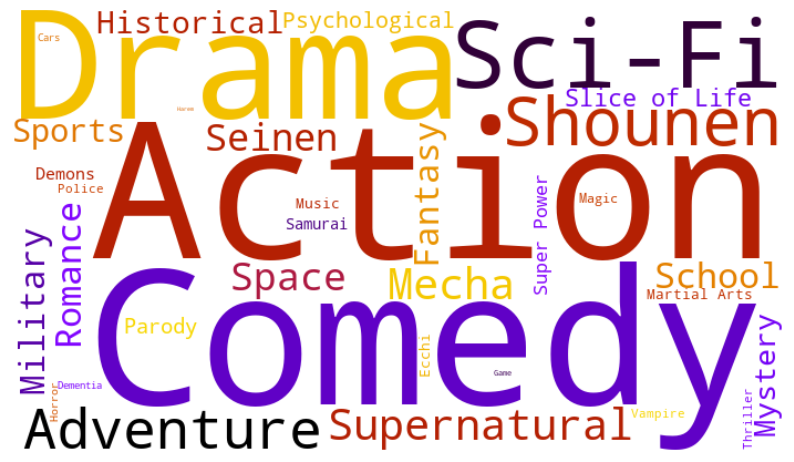

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [76]:
get_user_preferences(11880 , rating_df, anime_df , plot=True)

In [77]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)   

In [78]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)
similar_users

,similar_users,similarity
9,12839,0.314319
8,849,0.285049
7,3148,0.277386
6,10635,0.276708
5,12696,0.275022
4,12822,0.273106
3,1563,0.261586
2,5687,0.259092
1,14601,0.255034
0,9226,0.251696


In [79]:
user_pref = get_user_preferences(11880, rating_df, anime_df, plot=False)
user_pref

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [80]:
get_user_recommendations(similar_users,user_pref,anime_df, synopsis_df,rating_df,n=2)

,n,anime_name,Genres,Synopsis
0,8,Angel Beats!,"Action, Comedy, Drama, School, Supernatural","Otonashi awakens only to learn he is dead. A rifle-toting girl named Yuri explains that they are in the afterlife, and Otonashi realizes the only thing he can remember about himself is his name. Yuri tells him that she leads the Shinda Sekai Sensen (Afterlife Battlefront) and wages war against a girl named Tenshi. Unable to believe Yuri's claims that Tenshi is evil, Otonashi attempts to speak with her, but the encounter doesn't go as he intended. Otonashi decides to join the SSS and battle Tenshi, but he finds himself oddly drawn to her. While trying to regain his memories and understand Tenshi, he gradually unravels the mysteries of the afterlife."
1,8,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the world: a young and eccentric man known only by the name of L."


## HYBRID RECOMMENDER SYSTEM

In [81]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, anime_df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,anime_df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, anime_df, synopsis_df)
    
        if similar_animes is None or similar_animes.empty:
            # print(f"No similar anime found for {anime}. Skipping...")
            continue  # Skip this anime and move to the next one
        
        content_recommended_animes.extend(similar_animes["name"].tolist())

    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 



In [82]:
hybrid_recommendation(11880)

['Angel Beats!', 'Death Note', 'Code Geass:Lelouch of the Rebellion', 'Clannad', 'Your Name.', 'Spirited Away', 'Attack on Titan', 'Princess Mononoke', 'anohana:The Flower We Saw That Day', 'Demon Slayer:Kimetsu no Yaiba']
Anime Angel Beats! not found in encoding dictionary.
Anime Death Note not found in encoding dictionary.
Anime Code Geass:Lelouch of the Rebellion not found in encoding dictionary.
Anime Clannad not found in encoding dictionary.
Anime Your Name. not found in encoding dictionary.
Anime Spirited Away not found in encoding dictionary.
Anime Attack on Titan not found in encoding dictionary.
Anime Princess Mononoke not found in encoding dictionary.
Anime anohana:The Flower We Saw That Day not found in encoding dictionary.
Anime Demon Slayer:Kimetsu no Yaiba not found in encoding dictionary.


['Angel Beats!',
 'Death Note',
 'Code Geass:Lelouch of the Rebellion',
 'Clannad',
 'Your Name.',
 'Spirited Away',
 'Attack on Titan',
 'Princess Mononoke',
 'anohana:The Flower We Saw That Day',
 'Demon Slayer:Kimetsu no Yaiba']

In [83]:
recommended_animes = hybrid_recommendation(user_id=11880, user_weight=0.7, content_weight=0.3)
# print(recommended_animes)
recommended_animes

['Angel Beats!', 'Death Note', 'Code Geass:Lelouch of the Rebellion', 'Clannad', 'Your Name.', 'Spirited Away', 'Attack on Titan', 'Princess Mononoke', 'anohana:The Flower We Saw That Day', 'Demon Slayer:Kimetsu no Yaiba']
Anime Angel Beats! not found in encoding dictionary.
Anime Death Note not found in encoding dictionary.
Anime Code Geass:Lelouch of the Rebellion not found in encoding dictionary.
Anime Clannad not found in encoding dictionary.
Anime Your Name. not found in encoding dictionary.
Anime Spirited Away not found in encoding dictionary.
Anime Attack on Titan not found in encoding dictionary.
Anime Princess Mononoke not found in encoding dictionary.
Anime anohana:The Flower We Saw That Day not found in encoding dictionary.
Anime Demon Slayer:Kimetsu no Yaiba not found in encoding dictionary.


['Angel Beats!',
 'Death Note',
 'Code Geass:Lelouch of the Rebellion',
 'Clannad',
 'Your Name.',
 'Spirited Away',
 'Attack on Titan',
 'Princess Mononoke',
 'anohana:The Flower We Saw That Day',
 'Demon Slayer:Kimetsu no Yaiba']